In [1]:
# main file that includes all relevant sph functionality
from sph import *

# main file that includes all learning relevant functionality, not necessary to understand
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
%matplotlib notebook

In [2]:
numParticles = 2048 # set up here as PDF sampling and noise functions use this parameter

# different initial starting conditions, just pick one
# sinusoidal sampling
# pdf = lambda x: np.sin(x * np.pi * 4) + 2
# (excessive) sawtooth profile with step at x = 1 that has 0 density at x=-1 (barring periodic BC)
# pdf = lambda x: 1 + x
# square wave sampling
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
# sawtooth profile with step at x = 1 with at least a density of 1 everywhere
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1
# triangular density profile with peaks at x=-1 and x=1
# pdf = lambda x: np.abs(x) + 1
# gaussian density profile with narrow peak
# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# uniform density profile, mostly for debugging
# pdf = lambda x: np.ones_like(np.array(x))
# octave noise based on perlin noise
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
# low frequency sinusoidal sampling,  mostly to test the interp process
# noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)

In [3]:
def computeLaminarViscosity(i, j, ri, rj, Vi, Vj, distances, radialDistances, support, numParticles : int, eps : float, rhoi, rhoj, ui, uj, alpha : float, beta: float, c0 : float, restDensity : float):
    gradW = kernelGradient(radialDistances, distances, support)

    uij = ui[i] - uj[j]
    rij = ri[i] - rj[j]
    rij = -distances * radialDistances
    
    mu_nom = support * (uij * rij)
    mu_denom = torch.abs(rij) + 0.01 * support**2
    mu = mu_nom / mu_denom
    
    
    nom = - alpha * c0 * mu + beta * mu**2
    denom = (rhoi[i] + rhoj[j]) / 2
    termL = Vi[j] * nom / denom
#     rab = rij / mu_denom    
    
    term = termL * gradW# * torch.sign(ri[j] - ri[i] + 0.01 * support **2)
#     term = alpha * 2 * Vj[j] / rhoj[j] * torch.abs(gradW) / rij2
    

#     xsphUpdate = scatter(pairwiseXSPH, fluidNeighbors[0], dim=0, dim_size = fluidPositions.shape[0],reduce='add')
    return scatter(term, i, dim=0, dim_size = Vi.shape[0], reduce='add')


def computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensities, particleSupport, restDensity, alpha, beta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances):
    laminarViscosity = computeLaminarViscosity(fluidNeighbors[0], fluidNeighbors[1], \
                                                                                      fluidPositions, fluidPositions, fluidAreas, fluidAreas,\
                                                                                      fluidDistances, fluidRadialDistances,\
                                                                                      particleSupport, fluidDensities.shape[0], 1e-7,\
                                                                                      fluidDensities, fluidDensities,\
                                                                                      fluidVelocities,fluidVelocities,
                                                                                      alpha, beta, c0, restDensity)
    
    return laminarViscosity

In [4]:
# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

In [5]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.0
diffusionAlpha = 1. # kinematic viscosity coefficient
diffusionBeta = 2.
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 10 # speed of sound used in kinematic viscosity

timesteps = 2048 # timesteps to be simulated
display(Latex(f'Estimated kinematic diffusion $\\mu\\approx\\frac{{1}}{{2(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport} = {1/6 * diffusionAlpha * c0 * particleSupport}$'))
# display(Latex(f'Estimated kinematic diffusion ? $\\zeta\approx\\frac{{5}}{{6(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport} = {1/6 * diffusionAlpha * c0 * particleSupport}$'))

<IPython.core.display.Latex object>

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if device == 'cpu' else torch.float32
print('Running on ', device, 'using type', dtype)

Running on  cuda using type torch.float32


In [7]:
def plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport):
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)

    xs = fluidPositions.detach().cpu().numpy()
    densityField = fluidDensity.detach().cpu().numpy()
    fig, axis = plt.subplots(1, 3, figsize=(18,6), sharex = False, sharey = False, squeeze = False)
    numSamples = densityField.shape[-1]
    # xs = np.linspace(-1,1,numSamples)
    fs = numSamples/2
    fftfreq = np.fft.fftshift(np.fft.fftfreq(xs.shape[-1], 1/fs/1))    
    x = densityField
    y = np.abs(np.fft.fftshift(np.fft.fft(x) / len(x)))
    axis[0,0].plot(xs, densityField)
    axis[0,1].loglog(fftfreq[fftfreq.shape[0]//2:],y[fftfreq.shape[0]//2:], label = 'baseTarget')
    f, Pxx_den = scipy.signal.welch(densityField, fs, nperseg=len(x)//32)
    axis[0,2].loglog(f, Pxx_den, label = 'baseTarget')
    axis[0,2].set_xlabel('frequency [Hz]')
    axis[0,2].set_ylabel('PSD [V**2/Hz]')
    fig.tight_layout()
    return fluidDensity

<IPython.core.display.Javascript object>


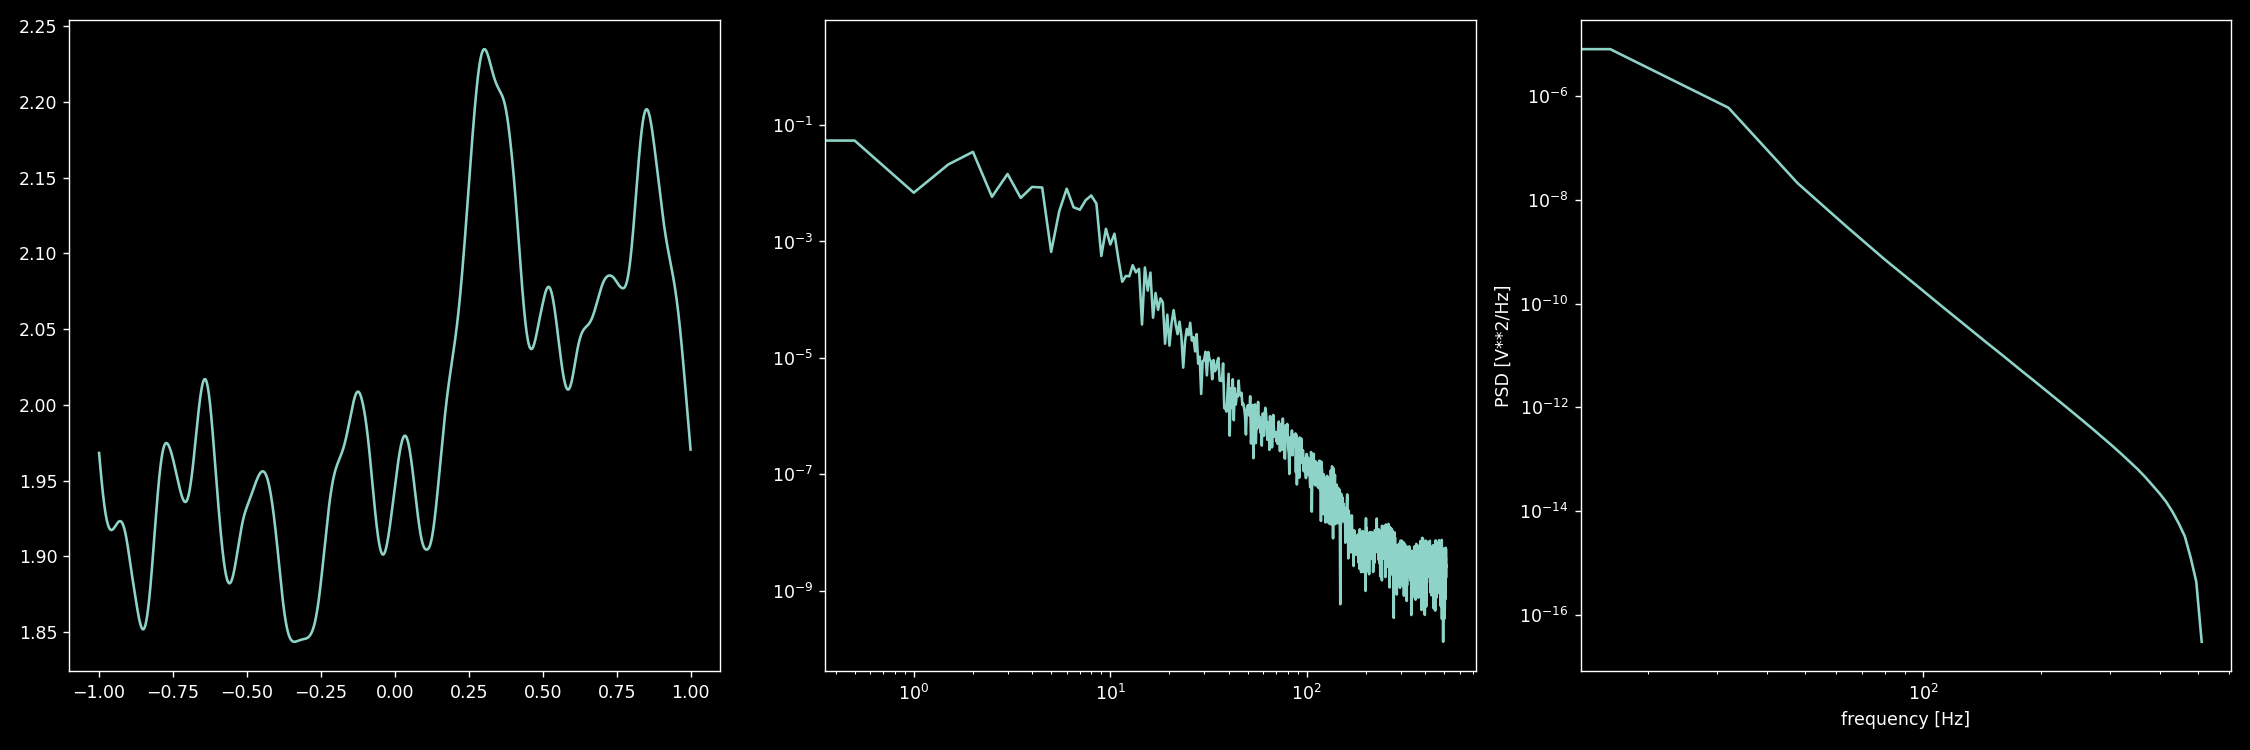

In [8]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStates = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [9]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


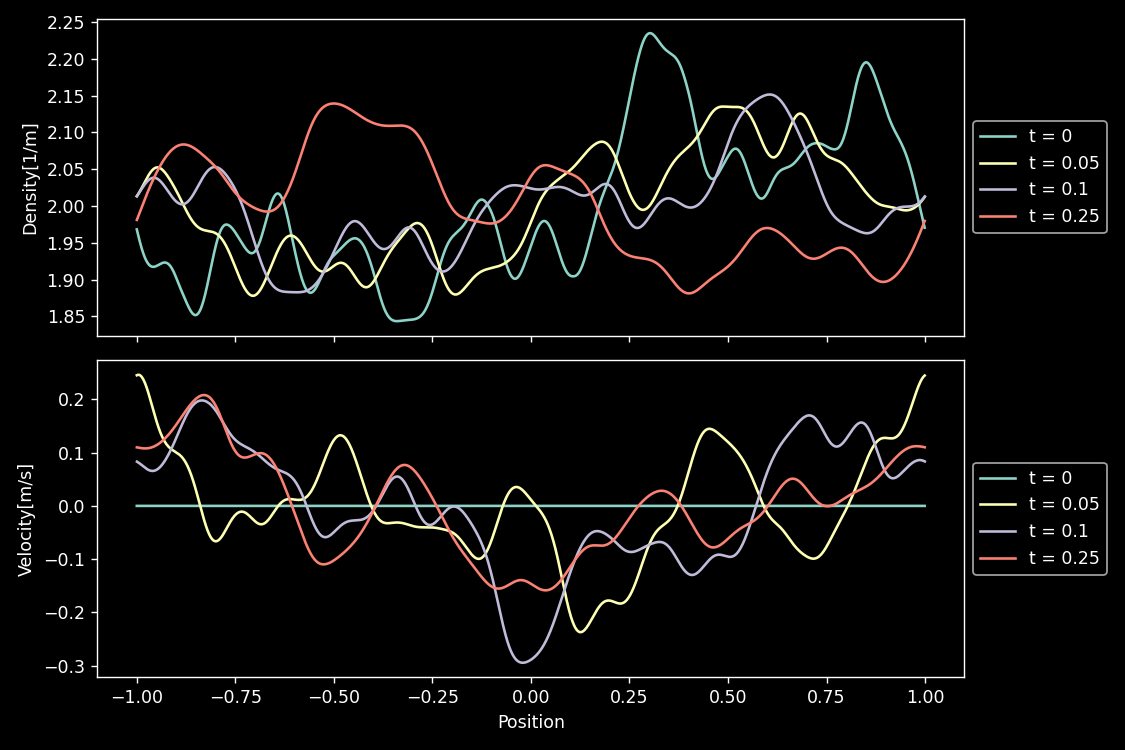

<IPython.core.display.Javascript object>


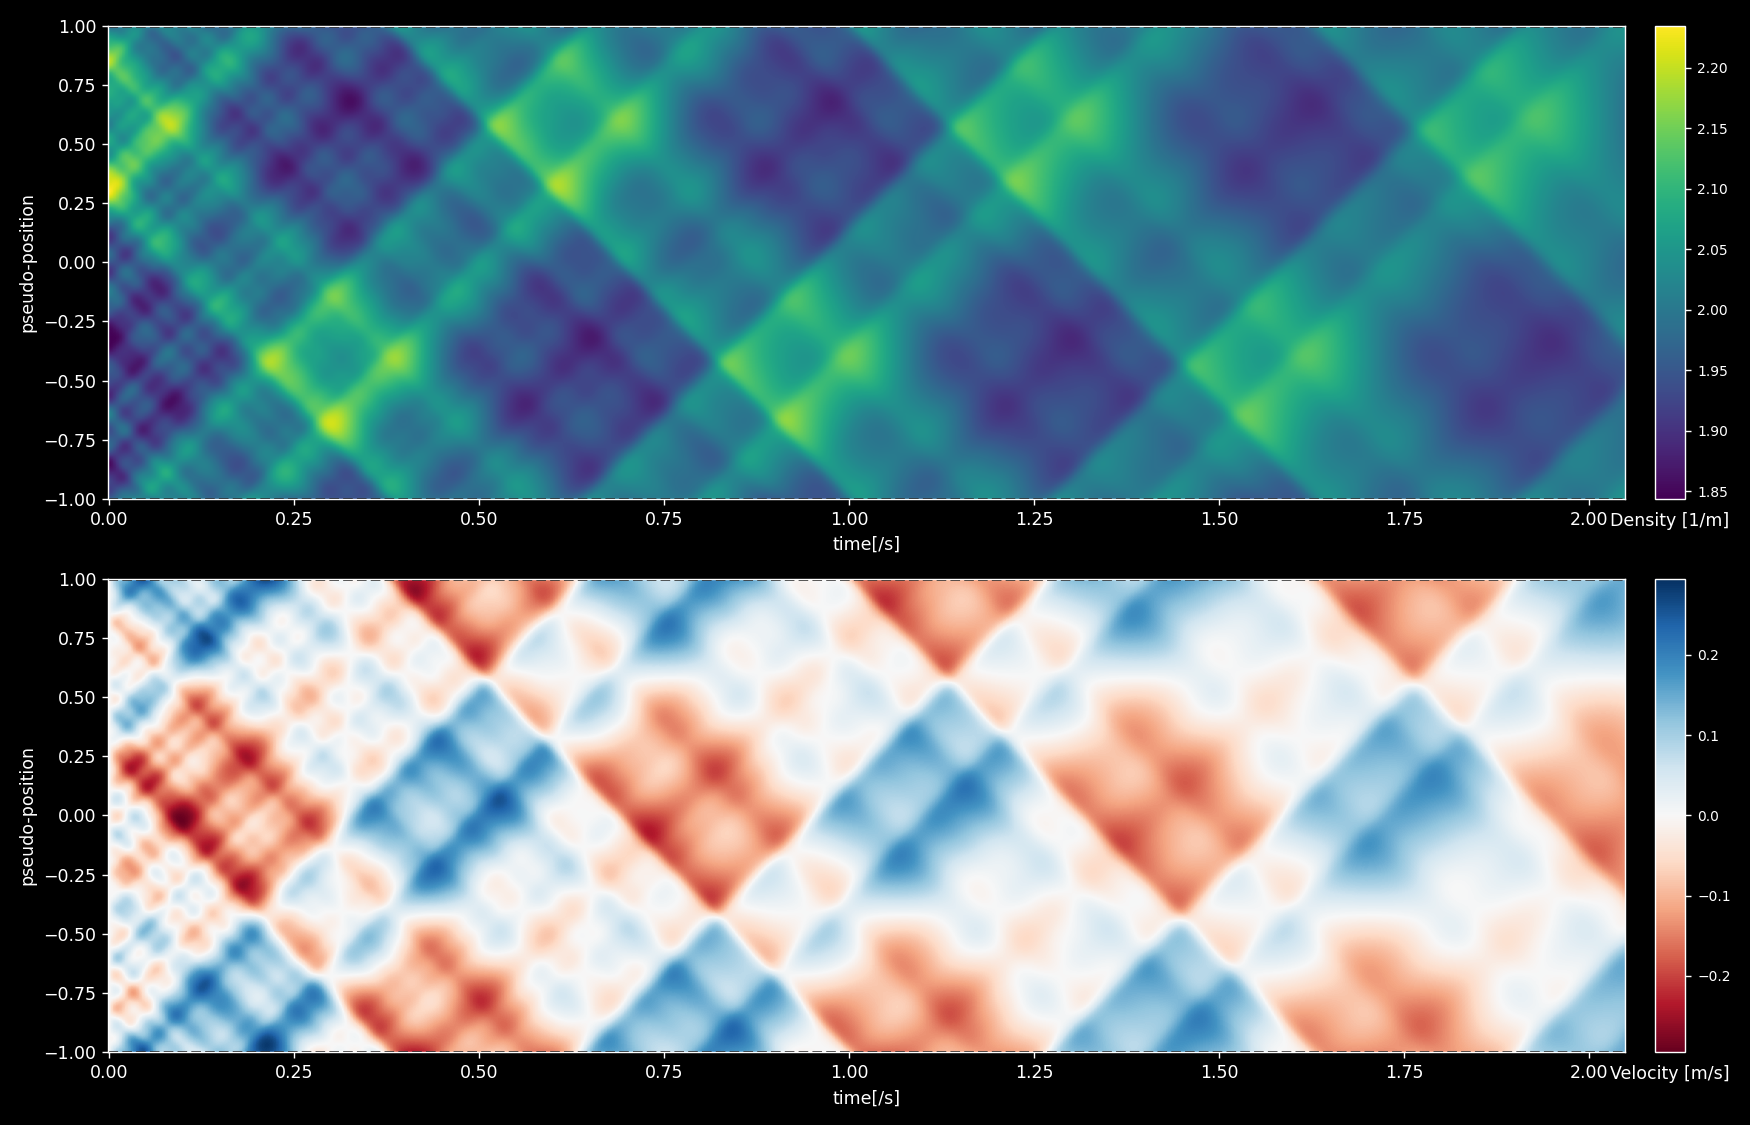

In [10]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


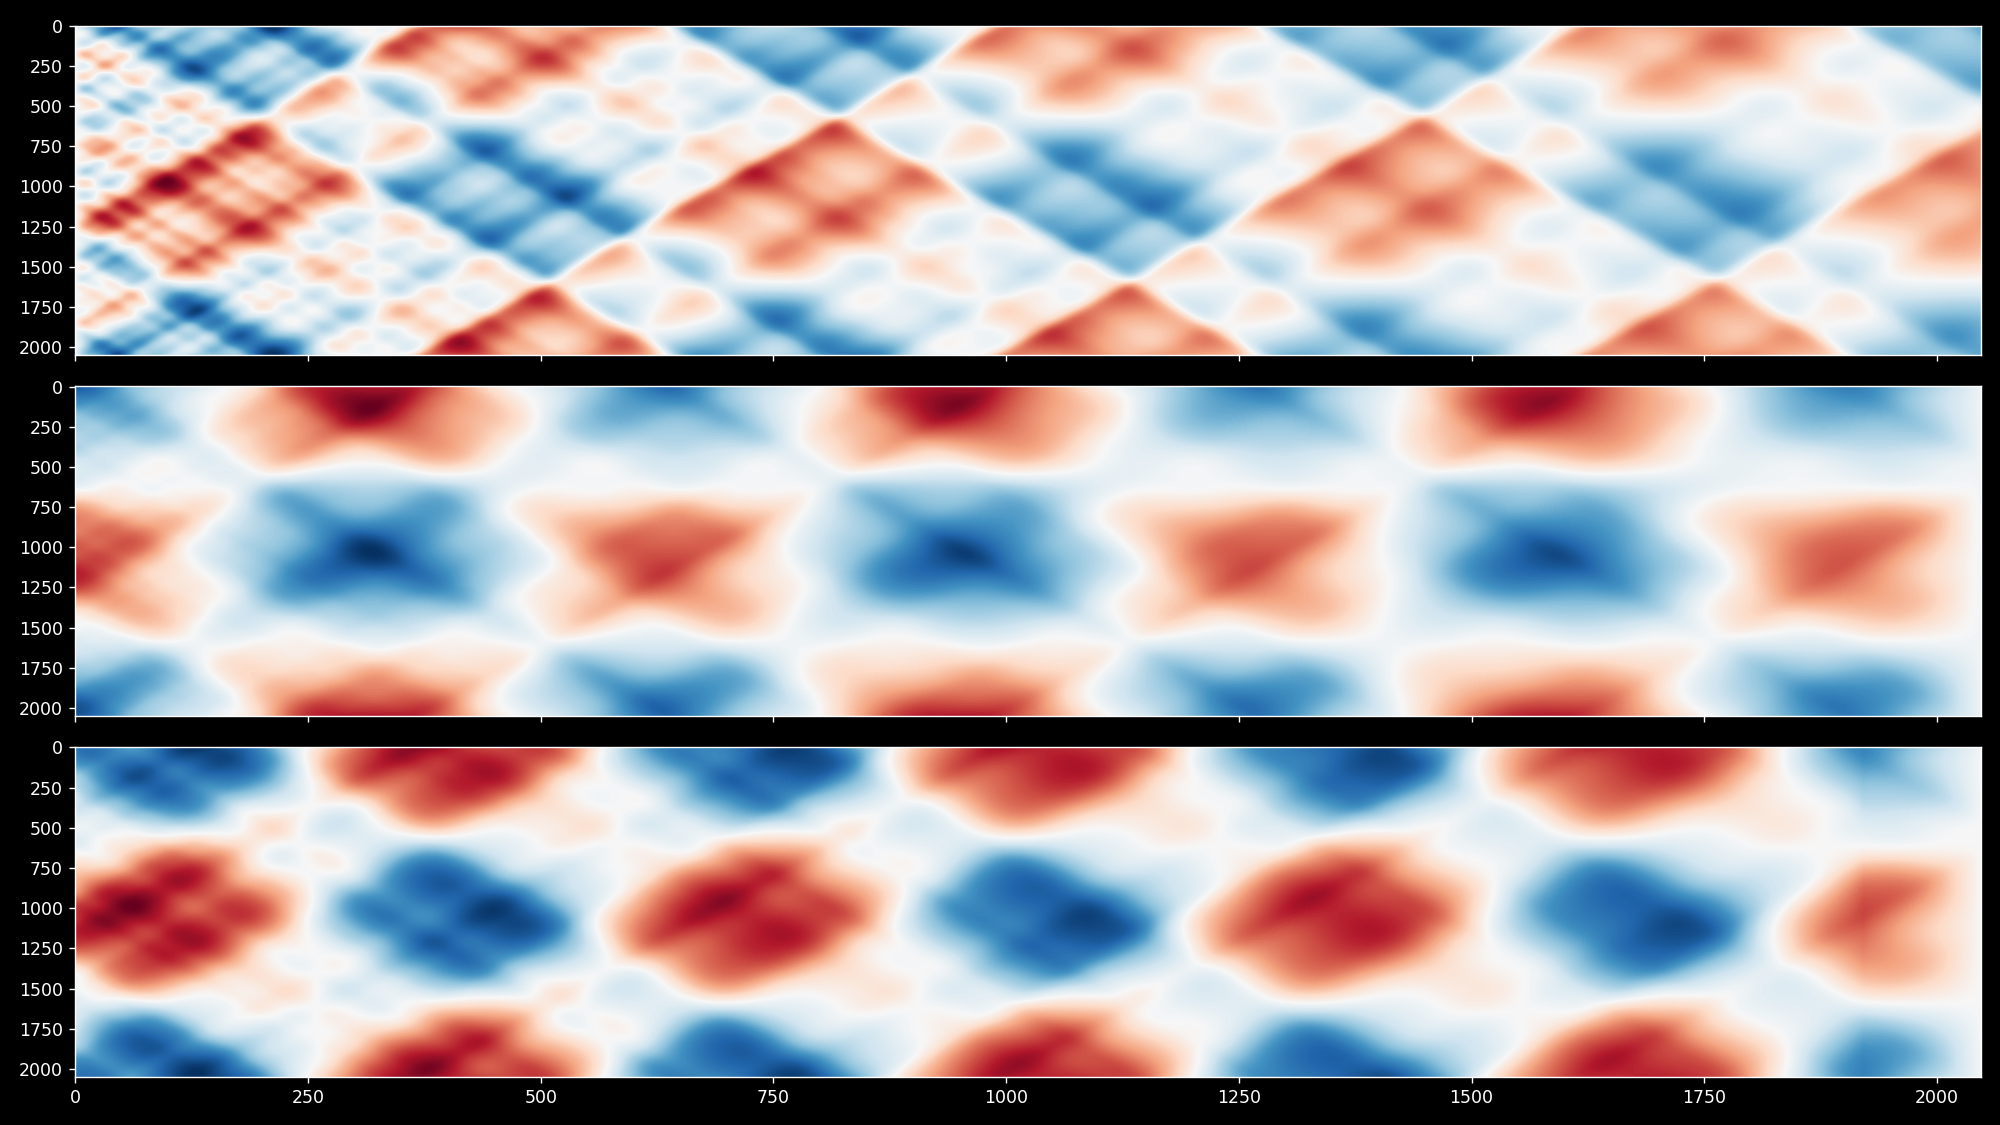

In [11]:
offset = 128

positions = simulationStates[:,0,:]
velocities = simulationStates[:,1,:]
accelerations = simulationStates[:,-2,:]
dx = dt * velocities + dt **2 * accelerations

x = dx.mT
cumsum = torch.cumsum(x, axis = 1)
s = torch.sum(x, axis = 1, keepdims=True)
r2lcumsum = x + s - cumsum
stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))

fig, axis = plt.subplots(3, 1, figsize=(16,9), sharex = True, sharey = False, squeeze = False)
axis[0,0].imshow(dx.mT.detach().cpu().numpy(), cmap = 'RdBu')
axis[0,0].axis('auto')

axis[1,0].imshow(r2lcumsum.detach().cpu().numpy(), cmap = 'RdBu')
axis[1,0].axis('auto')

axis[2,0].imshow(stacked.detach().cpu().numpy(), cmap = 'RdBu')
axis[2,0].axis('auto')

fig.tight_layout()

In [12]:
def processDataLoaderIter(pb, iterations, epoch, lr, dataLoader, dataIter, batchSize, model, optimizer, simulationStates, minDomain, maxDomain, particleSupport, lossFunction, getFeatures, getGroundTruth, stacked, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("process data loader"): 
        losses = []
        batchIndices = []
        weights = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            # get next batch from dataLoader, if all batches have been processed get a new iterator (which shuffles the batch order)
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
            # the actual batch processing step
            with record_function("process data loader[batch]"): 
                # reset optimizer gradients
                if train:
                    optimizer.zero_grad()
                # load data for batch                
                stackedPositions, features, groundTruth, stackedNeighbors, d = loadBatch(simulationStates, minDomain, maxDomain, particleSupport, bdata, getFeatures, getGroundTruth, stacked)
                
                
                # run the network layer
                prediction = model((features[:,None], features[:,None]), stackedNeighbors, d)
                # compute the loss
                lossTerm = lossFunction(prediction, groundTruth)
                loss = torch.mean(lossTerm)
                # store the losses for later processing
                losses.append(lossTerm.detach().cpu().numpy())
                # store the current weights before the update
                weights.append(copy.deepcopy({k: v.cpu() for k, v in model.state_dict().items()}))
#                 if hasattr(model, 'weight'):
#                     weights.append(torch.clone(model.weight.detach().cpu()).numpy())
                # update the network weights
                if train:
                    loss.backward()
                    optimizer.step()
                # create some information to put on the tqdm progress bars
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, 0, epoch, 0, lr, batchString, loss.detach().cpu().numpy()))
                pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(0, "", np.mean(np.vstack(losses))))
                pb.update()
                batchIndices.append(bdata)
        # stack the processed batches and losses for further processing
        bIndices  = np.hstack(batchIndices)
#         losses = np.vstack(losses)
#         losses = np.vstack(losses)
        # and return
        return bIndices, losses, weights

In [13]:
ignoredTimesteps = 256
batchSize = 4 # training batch size
# Training done on all timesteps except the last ignoredTimesteps
timestamps = np.arange(0,simulationStates.shape[0] - ignoredTimesteps - offset)
testBatch = np.arange(len(simulationStates) - ignoredTimesteps -offset, len(simulationStates) - offset)

In [14]:
# create pytorch dataloader (via pytorch geometric for convenience)
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

In [15]:
def getGroundTruth(bdata, stacked, simulationStates):
    gt = [stacked[:,i] /dt for i in bdata] # Learning Physics Update
    gt = [simulationStates[i,2,:] for i in bdata] # Learning Density
    groundTruth = torch.hstack(gt)[:,None]
    return groundTruth

def getFeatures(stackedPositions, stackedAreas, stackedVelocities, stackedUpdates):
    features = torch.ones_like(stackedAreas)
    
    return features   

def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

In [136]:
# Hyperparameters for the NN
lr = 1e-1 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
n = 15 # number of weights per continuous convolution
basis = 'rbf square' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer
windowFn = None # set to None for now
normalized = False # rbf normalization, can be safely ignored

<IPython.core.display.Javascript object>


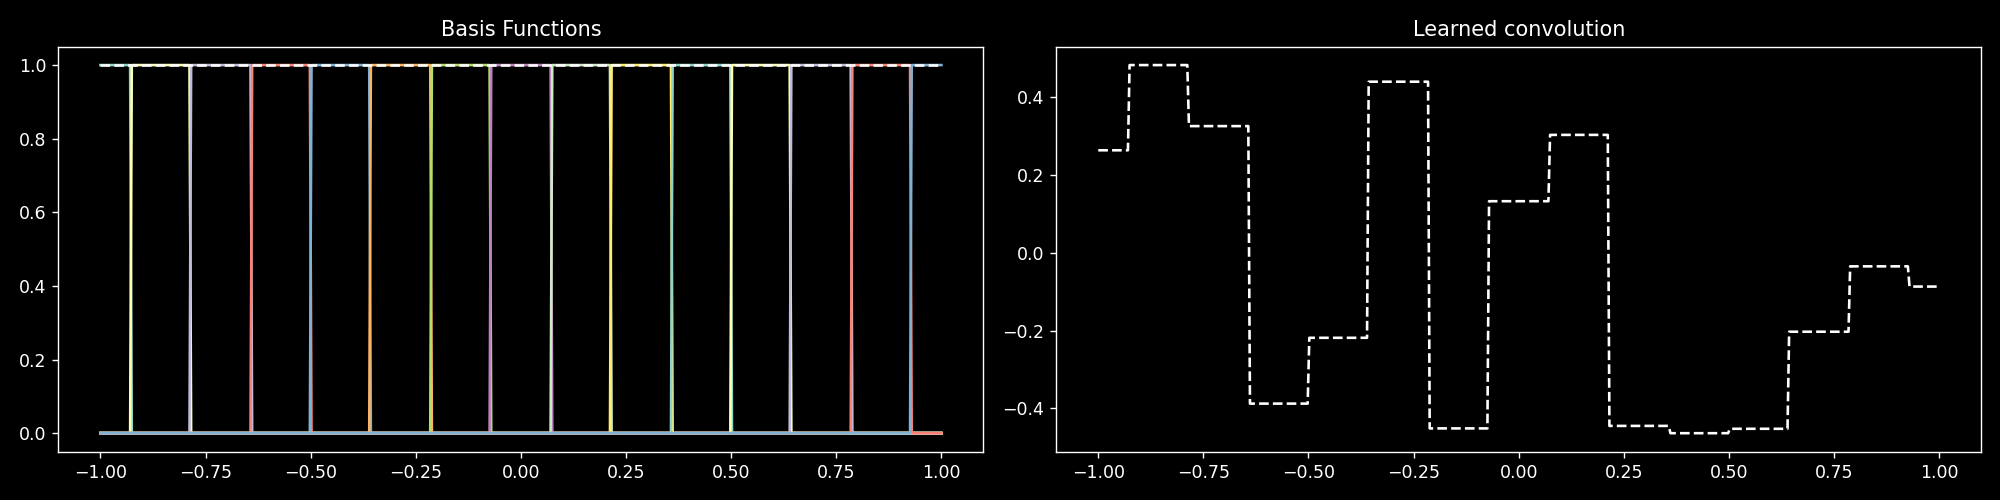

In [137]:
# Setup a single layer using the rbf convolution (which is a generalized CConv)
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized).to(device)
# Adjusting the weight initialization for testing out things, defaults to uniform -0.05 to 0.05 as per the CConv paper
# torch.nn.init.uniform_(model.weight,0.0,0.3)
torch.nn.init.uniform_(model.weight,-.50,.50)
# Create optimizer for the single layer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
weightFn = lambda x: np.exp(-(x * 2.5)**2)
weightFn = getWindowFunction('Wendland2_1D')
# with torch.no_grad():    
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport
plotWeights({k: v.cpu() for k, v in model.state_dict().items()}, basis, normalized)
# count_parameters(model)

# plotRandomWeights(32, n, basis, 'Wendland2_1D')

In [138]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
lossArray = []
batches = []
weights = []
testing = []
# the actual learning process
for epoch in range(epochs):
    losses = []
    b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                    dataLoader, dataIter, batchSize, model, optimizer, \
                                    simulationStates, minDomain, maxDomain, particleSupport, \
                                    lossFunction, getFeatures, getGroundTruth, stacked,\
                                    train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)
    lossArray.append(l)
    batches.append(b)
    weights.append(w)
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


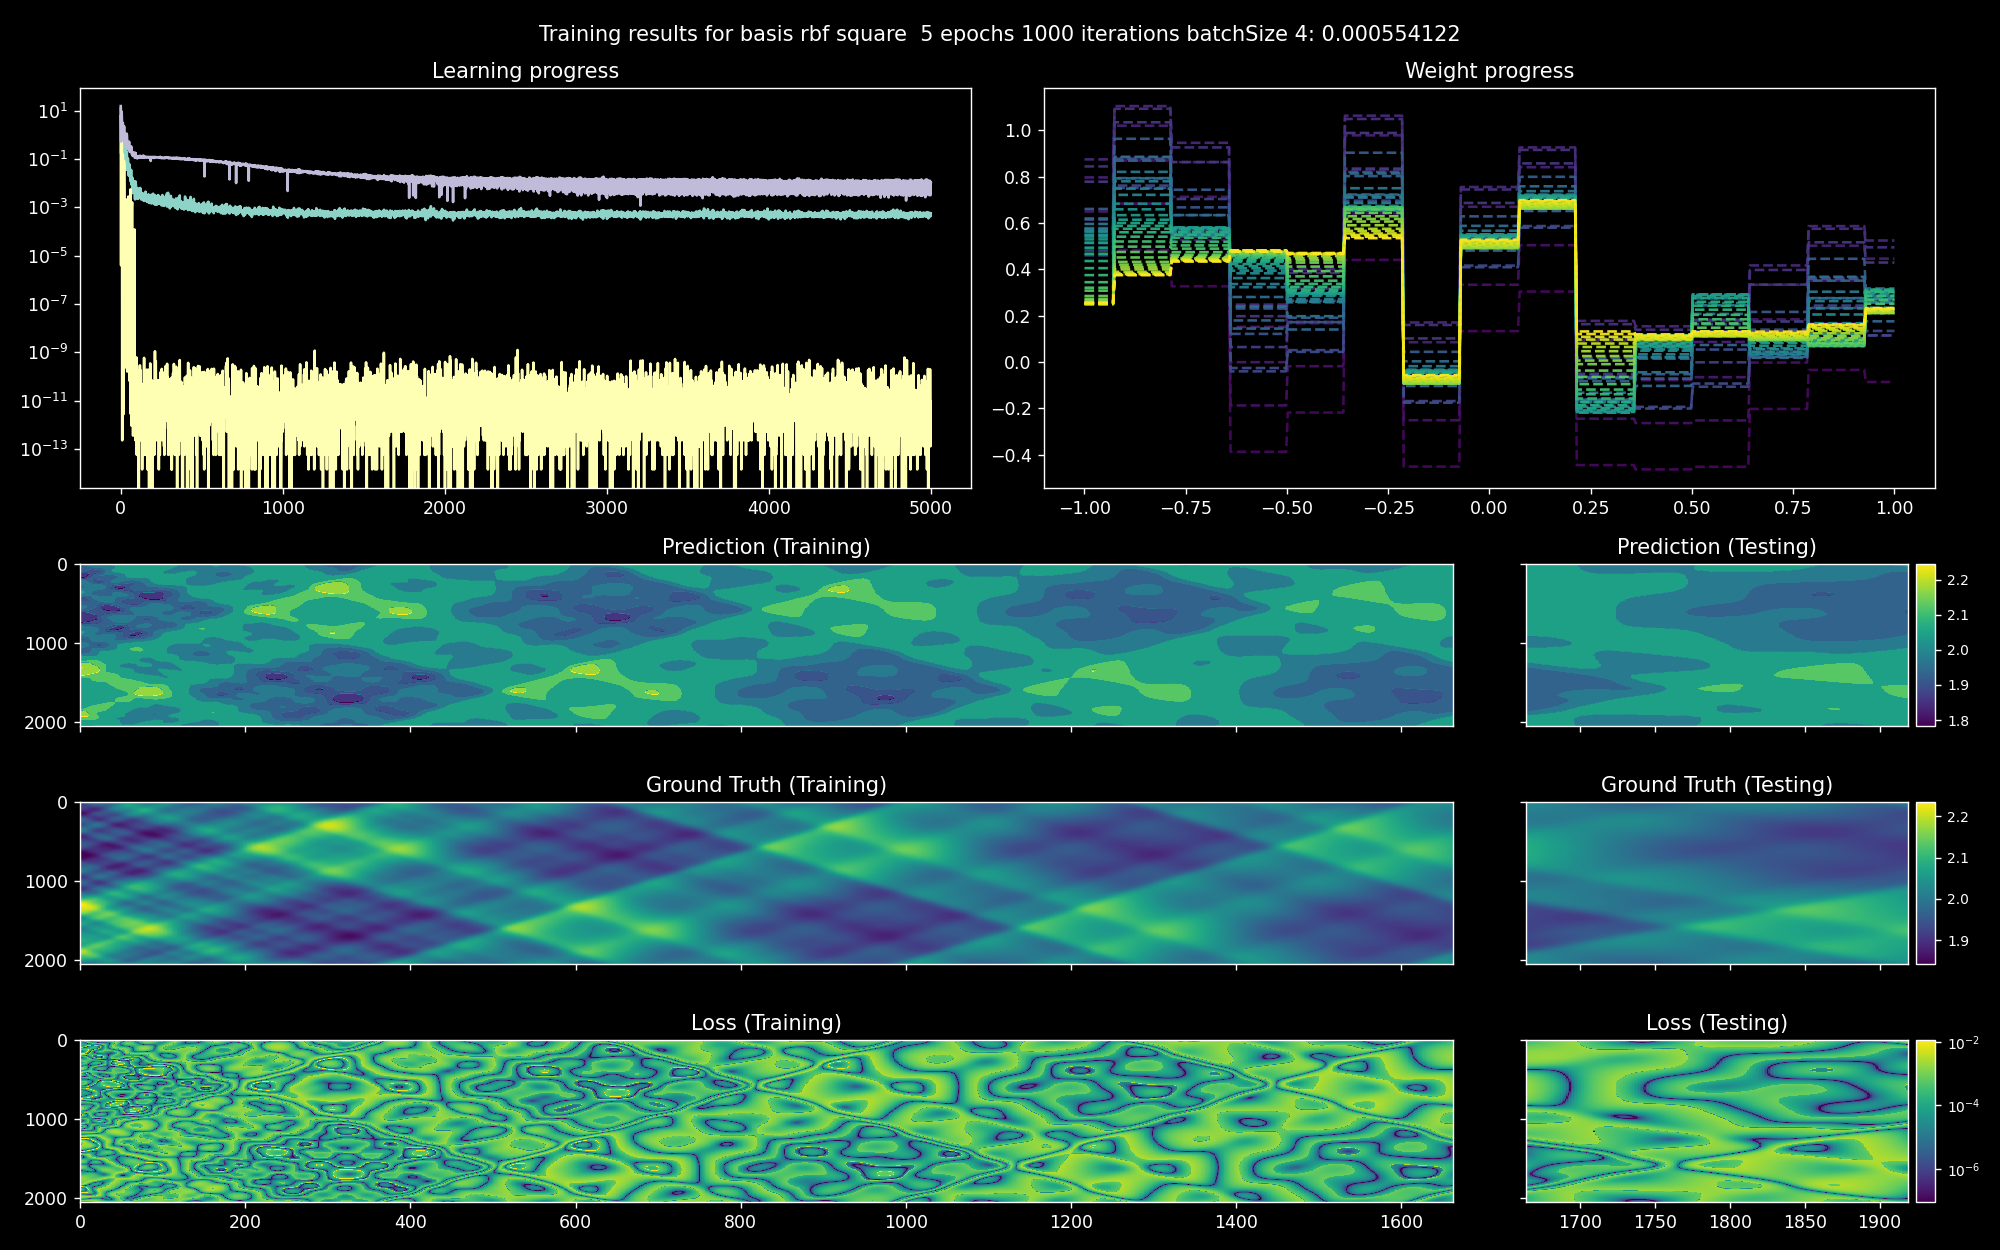

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [139]:
fig, axis = plotAll(model, device, weights, basis, normalized, iterations, epochs, numParticles, batchSize, lossArray, simulationStates, minDomain, maxDomain, particleSupport, timestamps, testBatch, lossFunction, getFeatures, getGroundTruth, stacked)

<IPython.core.display.Javascript object>


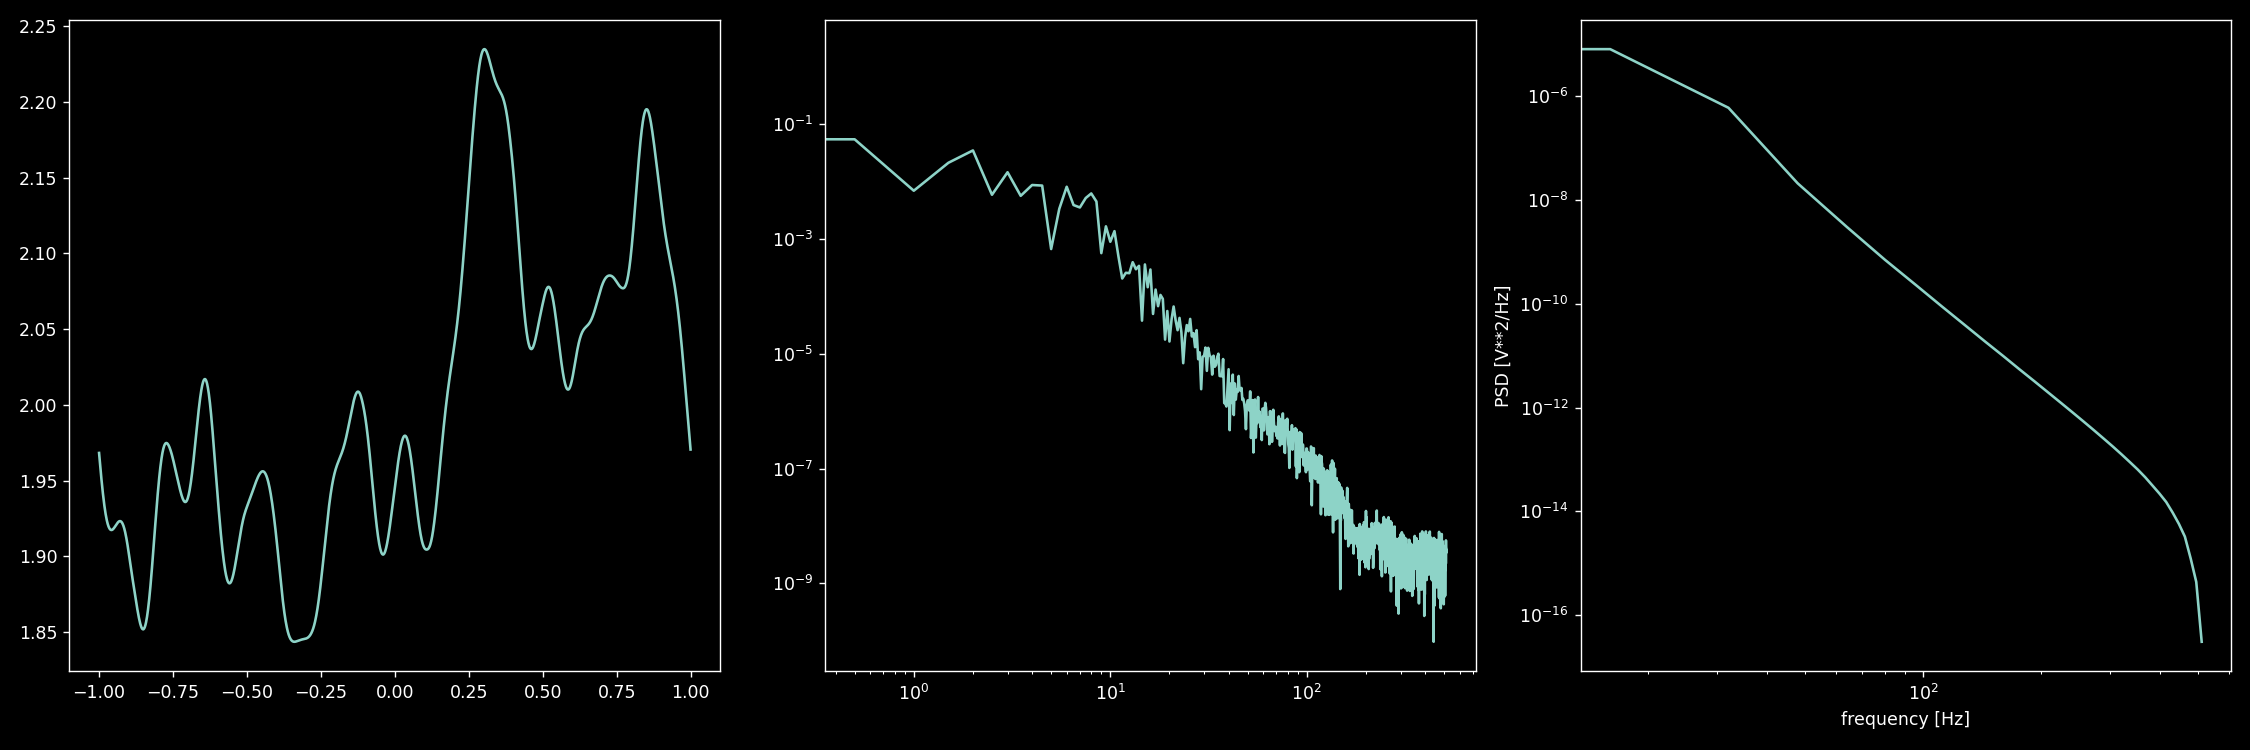

In [140]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStatesML = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [141]:

def prepareNetwork(fluidPositions, fluidAreas, fluidVelocities, minDomain, maxDomain, particleSupport, getFeatures):
    ghosts = createGhostParticles(fluidPositions, minDomain, maxDomain) 
    # perform neighborhood search for batch and split the data into 3 separate lists
    neighborInformation = findNeighborhoods(fluidPositions, ghosts, particleSupport) 
    neighbors = neighborInformation[0]
    radialDistances = neighborInformation[1]
    distances = neighborInformation[2]
    # compute the density on the given batch data
    
#     # all data so far is in lists of equal length, merge lists with special attention to the neighborlist to make sure indices are pointing to the correct particles
#     stackedPositions = torch.hstack(positions).type(torch.float32)
#     stackedAreas = torch.hstack(areas).type(torch.float32)
#     stackedVelocities = torch.hstack(velocities).type(torch.float32)
#     stackedUpdates = torch.hstack(updates).type(torch.float32)
#     stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
#     stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
#     stackedDistances = torch.hstack(distances).type(torch.float32)
#     stackedDensities = torch.hstack(densities).type(torch.float32)
    # tensor of ones to make learning easier
    ones = torch.ones_like(fluidAreas)
    # compute the signed distances needed for the network layer, uses the radialDistances and directions computed before                
    d = radialDistances[:,None] * torch.sign(distances[:,None])  
    
    return fluidPositions, getFeatures(fluidPositions, fluidAreas, fluidVelocities, None), neighbors, d


In [142]:
prepareNetwork(fluidPositions, fluidAreas, fluidVelocities, minDomain, maxDomain, particleSupport, getFeatures)

(tensor([-1.0000, -0.9990, -0.9980,  ...,  0.9970,  0.9980,  0.9990],
        device='cuda:0'),
 tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'),
 tensor([[   0,    0,    0,  ..., 2047, 2047, 2047],
         [2041, 2042, 2043,  ...,    4,    5,    6]], device='cuda:0'),
 tensor([[-0.8856],
         [-0.7596],
         [-0.6333],
         ...,
         [ 0.6362],
         [ 0.7639],
         [ 0.8917]], device='cuda:0'))

In [143]:


# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    
    stackedPositions, features, stackedNeighbors, d = prepareNetwork(fluidPositions, fluidAreas, fluidVelocities, minDomain, maxDomain, particleSupport, getFeatures)
    with torch.no_grad():
        fluidDensity = model((features[:,None], features[:,None]), stackedNeighbors, d)[:,0]
#     print(fluidDensity)
    #  3. Compute \rho using an SPH interpolation
#     model()
    
#     model((features[:,None], features[:,None]), stackedNeighbors, d)
    
#     fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure


In [144]:

# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdateML(model, x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdateML(model, x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdateML(model, x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStatesML.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStatesML = torch.stack(simulationStatesML)


  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


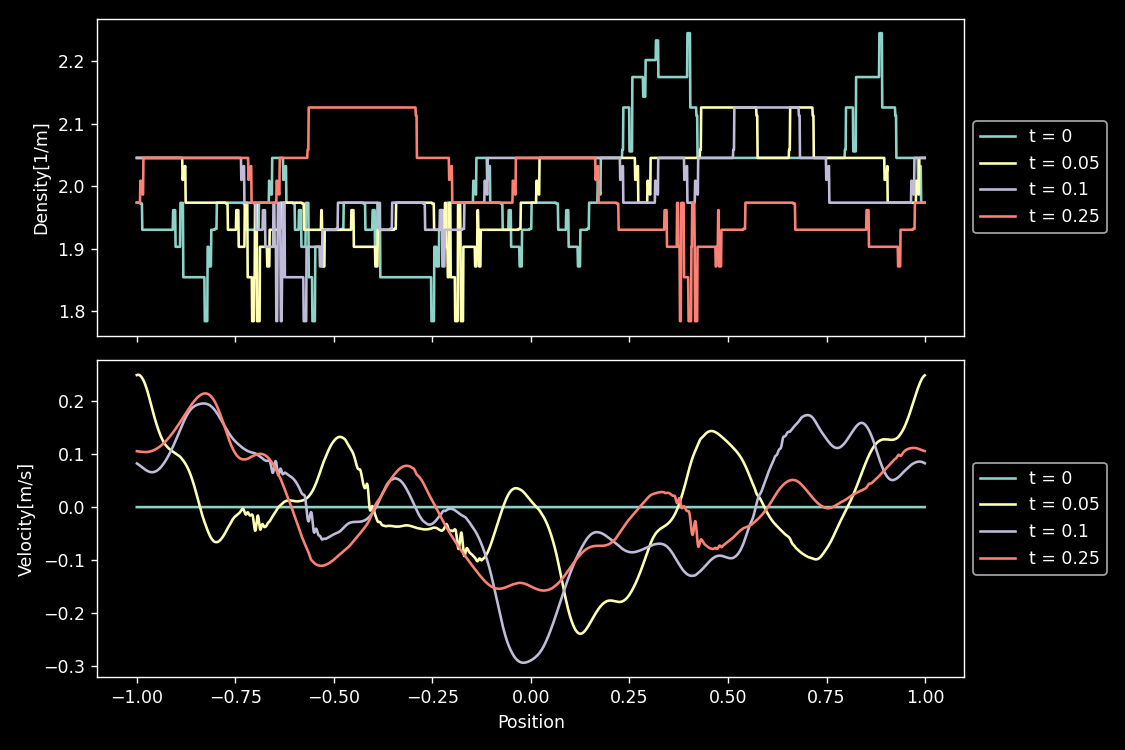

In [145]:

plotSimulationState(simulationStatesML, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])

<IPython.core.display.Javascript object>


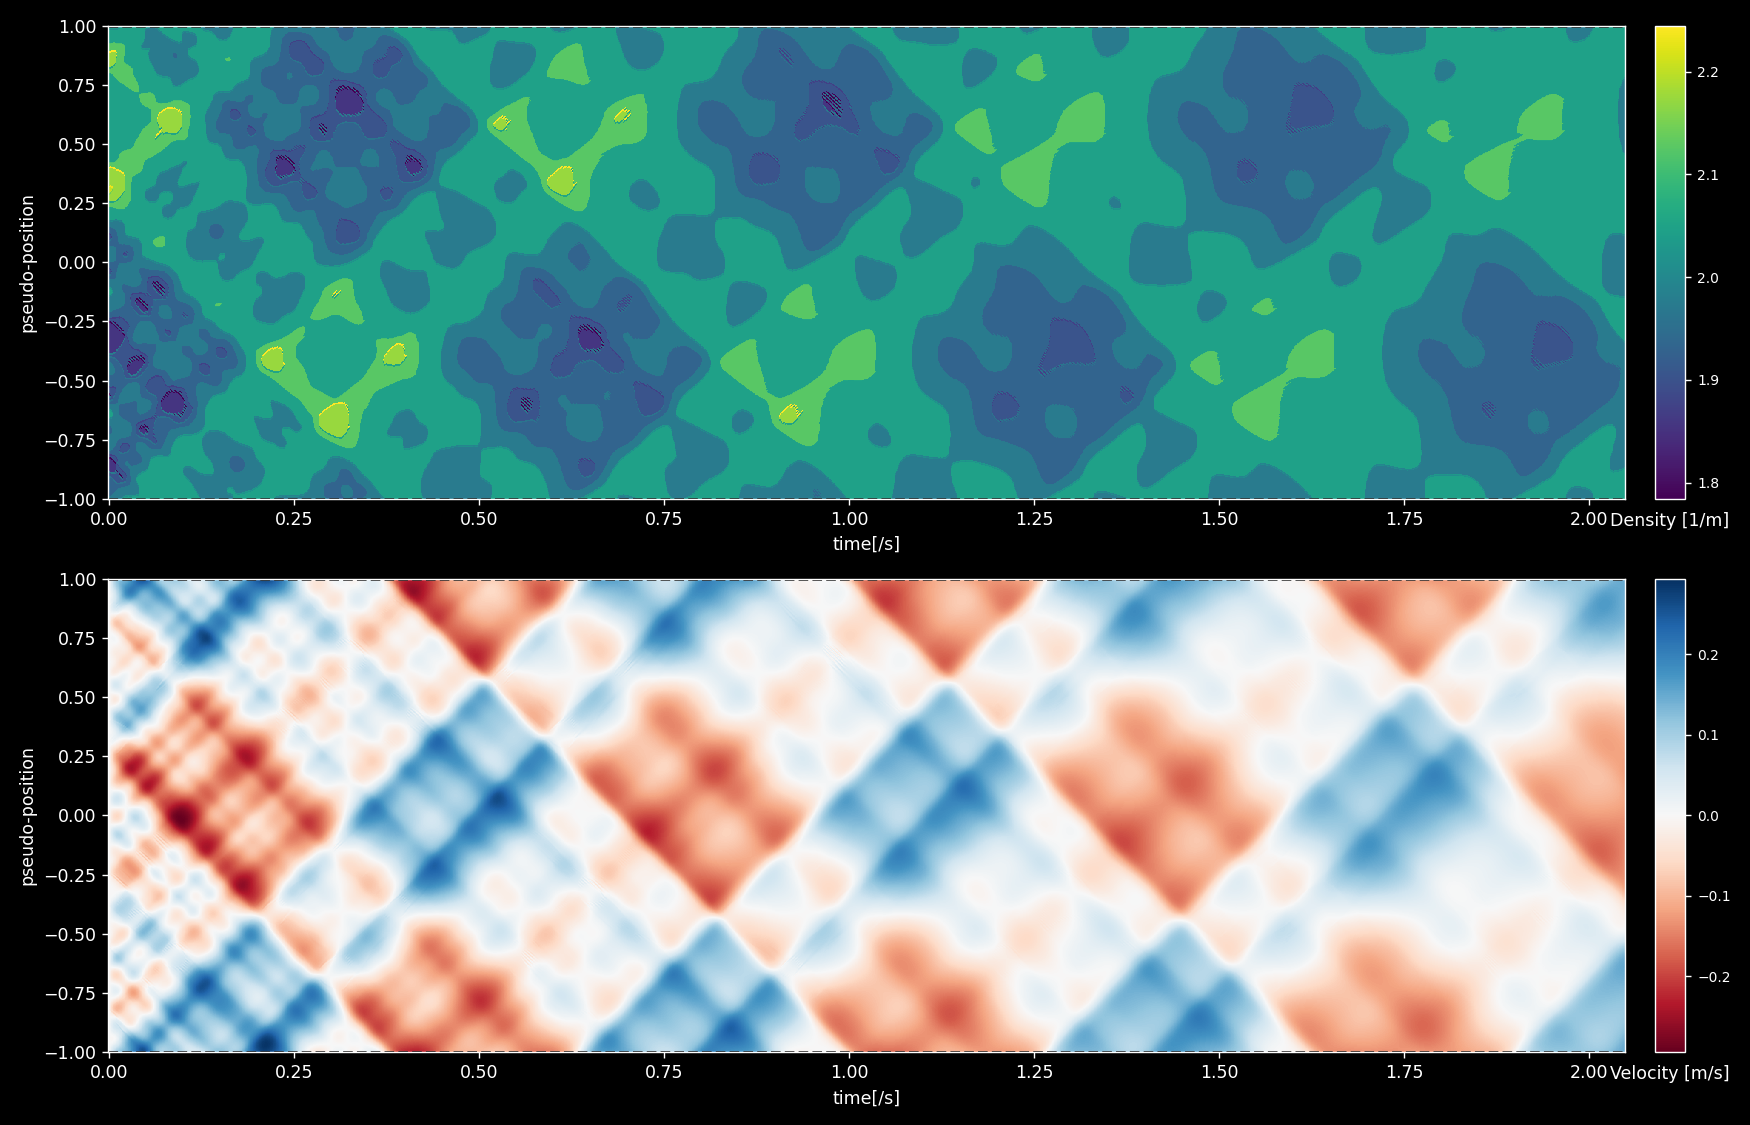

In [146]:

regularPlot(simulationStatesML, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


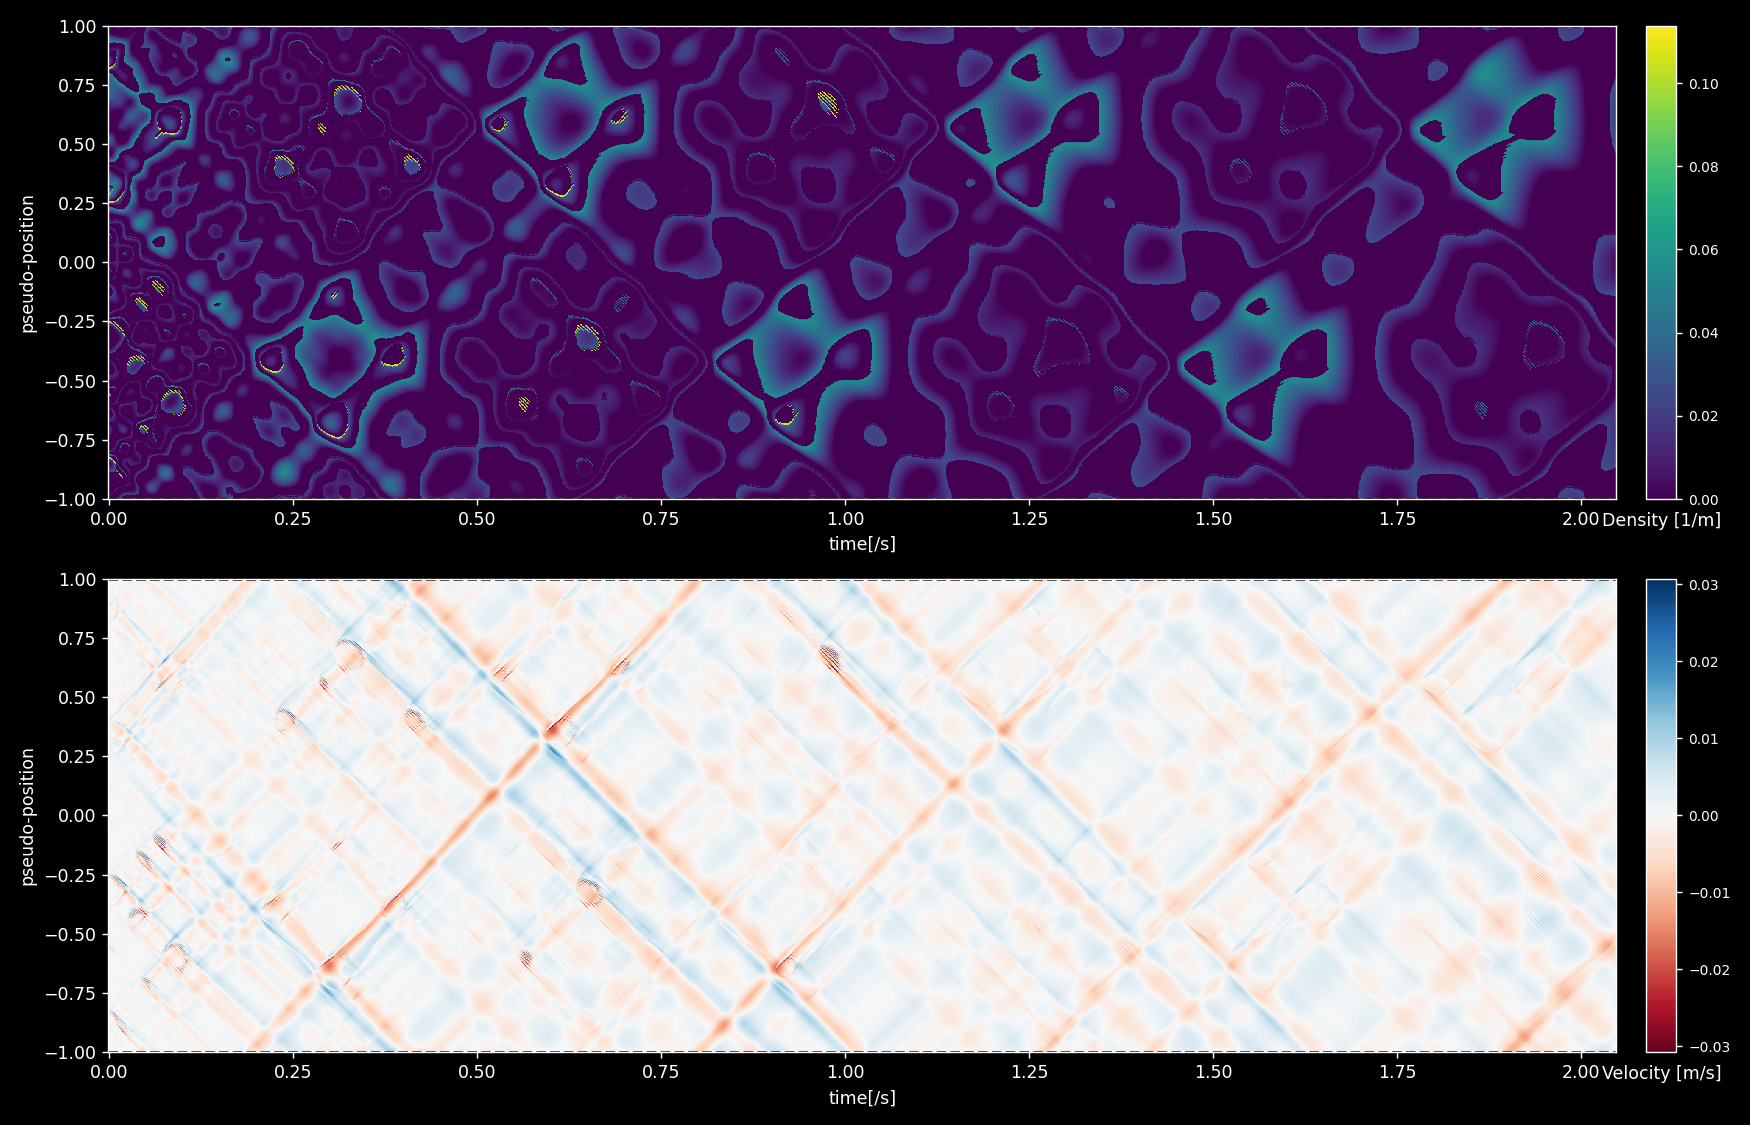

In [147]:
simulationStatesDiff = simulationStates - simulationStatesML
simulationStatesDiff[:,0] = simulationStates[:,0]

regularPlot(simulationStatesDiff, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)